## 不均衡データ

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

creditcard = pd.read_csv('creditcard.csv', sep=',')
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<AxesSubplot:xlabel='Time', ylabel='Amount'>

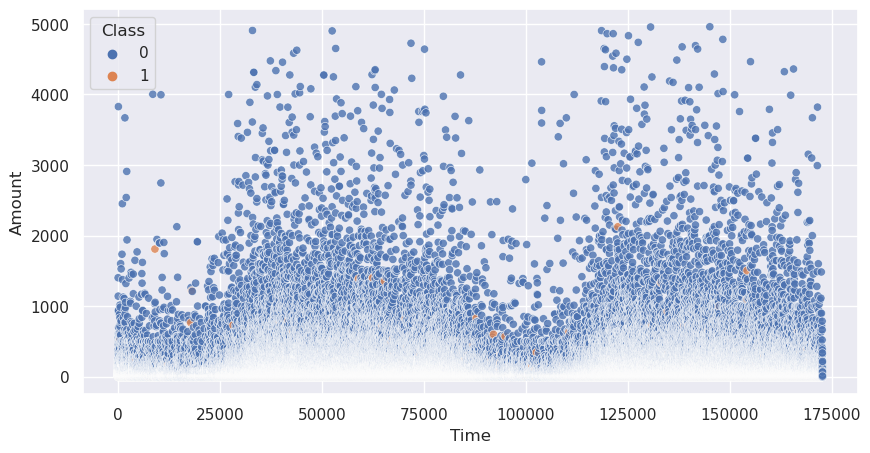

In [15]:
data = creditcard[creditcard['Amount']<5000][['Time', 'Amount', 'Class']]
sns.set()
plt.figure(figsize=[10,5])
sns.set_style('darkgrid')
sns.scatterplot(data=data, x='Time', y = 'Amount', hue = 'Class', alpha=0.8)

In [17]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

In [27]:
X = data.loc[:, data.columns != 'Class']
y = data['Class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)


[0 0 0 ... 0 0 0]


In [44]:
#0.5以上の確率は1, 0.5未満は0
pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, pred)
matrix = pd.DataFrame(cm)

#なぜMultiIndex指定？
matrix.columns = [['予測_負例(0)', '予測_正例(1)']]
matrix.index = [['実際_負例(0)', '実際_正例(1)']]

matrix

,予測_負例(0),予測_正例(1)
実際_負例(0),85295,0
実際_正例(1),131,0


In [49]:
#評価

print('Accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
print('Precision = ', precision_score(y_true=y_test, y_pred=y_pred, zero_division=0).round(decimals=3))
print('Recall = ', recall_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
print('F1 score = ', f1_score(y_true=y_test, y_pred=y_pred).round(decimals=3))

Accuracy =  0.998
Precision =  0.0
Recall =  0.0
F1 score =  0.0


In [54]:
#fitに要する時間
import time

time_1 = time.time()

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

time_2 = time.time()

print(time_2-time_1) #13秒掛かっている

12.962436437606812


## アプローチ

In [59]:
#アンダーサンプリング
from imblearn.under_sampling import RandomUnderSampler

target = 'Class'
rs = RandomUnderSampler(random_state=42)

#_はアンダーサンプリングしたindexとclassを返す
under_sampling ,_ = rs.fit_resample(creditcard, creditcard[target])

print('*'*20)
print('＜元のデータ＞')
print('0の件数：%d'%len(creditcard.query(f'{target}==0')))
print('1の件数：%d'%len(creditcard.query(f'{target}==1')))
print('*'*20)
print('＜アンダーサンプリング後のデータ＞')
print('0の件数：%d'%len(under_sampling.query(f'{target}==0')))
print('1の件数：%d'%len(under_sampling.query(f'{target}==1')));


********************
＜元のデータ＞
0の件数：284315
1の件数：492
********************
＜アンダーサンプリング後のデータ＞
0の件数：492
1の件数：492


<AxesSubplot:xlabel='Time', ylabel='Amount'>

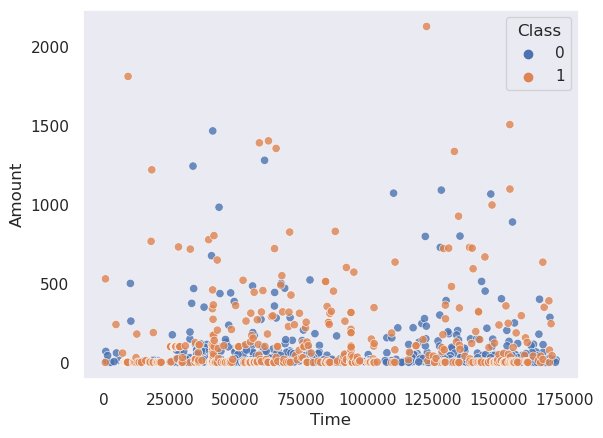

In [60]:
#グラフ表示
data = under_sampling[['Time', 'Amount', 'Class']]
plt.grid()
sns.scatterplot(data = data, x ='Time', y = 'Amount', hue = 'Class', alpha=0.8)

## アンダーバギング

In [90]:
import lightgbm as lgb
from tqdm import tqdm

def lgbm_train(X_train, X_valid, y_train, y_valid):
    global model
    model = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        boosting_type='gbdt',
        num_leaves=30,
        learning_rate=0.01,
        feature_fraction=0.9,
        subsample=0.8,
        max_depth=12,
        min_data_in_leaf=12)
    model.fit(X_train, y_train)
    return model

#アンダーダンプリング
def bagging(seed):
    sampler = RandomUnderSampler(random_state=seed, replacement=True)
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    
    #バギング
    model_bagging = lgbm_train(X_train2, X_valid, y_train2, y_valid)
    return model_bagging

#分析
X = creditcard.drop(columns='Class', axis=1)
y = creditcard['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


# 学習
models = []
for i in range(10):
    models.append(bagging(i))



[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 383, number of negative: 230310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 230693, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001660 -> initscore=-6.399147
[LightGBM] [Info] Start training from score -6.399147
[LightGBM] [Wa

In [88]:
#plot_confusion_matrixはpython 1.2.0以降削除された
from sklearn.metrics import roc_auc_score
# , plot_confusion_matrix

# 予測
y_preds = []
for m in tqdm(models):
   y_preds.append(m.predict(X_test))

# 評価
y_preds_bagging = sum(y_preds)/len(y_preds)
auc = roc_auc_score(y_test, y_preds_bagging)
print(f'AUC： {round(auc, 2)}')

# 混同行列
matrix = confusion_matrix(y_preds_bagging, y_test)
print(matrix)

# 評価
print('Accuracy = ', accuracy_score(y_true=y_test, y_pred=y_preds_bagging).round(decimals=3))
print('Precision = ', precision_score(y_true=y_test, y_pred=y_preds_bagging, zero_division=0).round(decimals=3))
print('Recall = ', recall_score(y_true=y_test, y_pred=y_preds_bagging).round(decimals=3))
print('F1 score = ', f1_score(y_true=y_test, y_pred=y_preds_bagging).round(decimals=3))

 20%|██        | 2/10 [00:00<00:00, 15.64it/s]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warn

100%|██████████| 10/10 [00:00<00:00, 23.37it/s]


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warn

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_preds_bagging, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot

<bound method ConfusionMatrixDisplay.plot of <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f2bda4a7a90>>

## オーバーサンプリング

In [93]:
#SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X = creditcard.drop(columns='Class', axis=1)
y = creditcard['Class']

X_sample, y_sample = sm.fit_resample(X, y)

In [107]:
over_sampling = X_sample
over_sampling['Class'] = y_sample

value_counts = over_sampling['Class'].value_counts()

In [109]:
df = pd.DataFrame()
df['ラベル'] = value_counts.index
df['件数'] = value_counts.values
ratio=[]
ratio.append((value_counts.values[0] / len(over_sampling['Class']) * 100).round(decimals=2).astype('str'))
ratio.append((value_counts.values[1] / len(over_sampling['Class']) * 100).round(decimals=2).astype('str'))
df['割合'] = [f'{ratio[0]}%', f'{ratio[1]}%']
print(f"全レコード数：{len(over_sampling['Class'])}")
df


全レコード数：568630


,ラベル,件数,割合
0,0,284315,50.0%
1,1,284315,50.0%


<AxesSubplot:xlabel='Time', ylabel='Amount'>

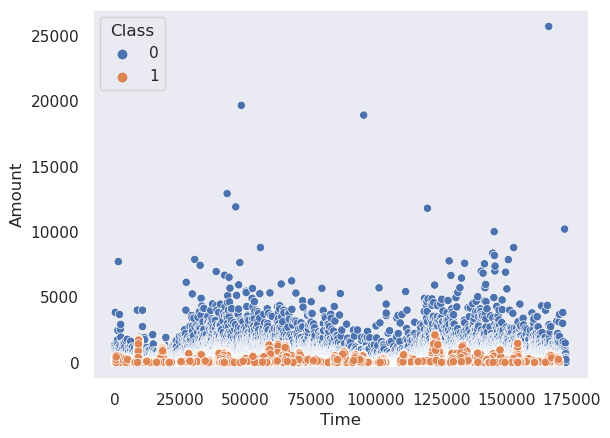

In [111]:
data = over_sampling[['Time', 'Amount', 'Class']]
plt.grid()
sns.scatterplot(data = data, x='Time', y='Amount', hue='Class')

<AxesSubplot:xlabel='Time', ylabel='Amount'>

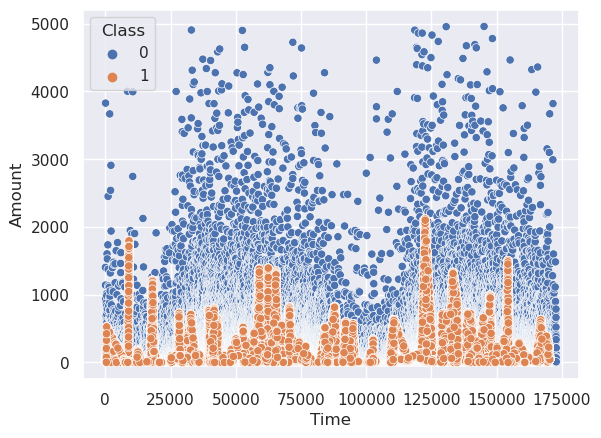

In [112]:
#縦軸を縮めて
data = over_sampling[over_sampling['Amount']<5000][['Time', 'Amount', 'Class']]
sns.scatterplot(data = data, x ='Time', y = 'Amount', hue = 'Class')